# Age Estimator using Deep CNNs  - 

**Dataset : UTKFace**

UTKFace dataset is a large-scale face dataset with long age span (range from **0 to 116 years old**). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

In this notebook, I have used the **aligned and cropped** faces available to train my models. Needless to say, any face input for testing must be cropped and aligned vertically to large extent.

#### Working Methodology - 

I initially tried all 3 fundamental convolutional layers - `Conv2D`, `SeperableConv2D` and `Conv2DTranspose`. I found `SeperableConv2D` to perform the best. Then I tried using some key arguments of it and noted down its results.
Finally, for the best among those, I tested the performance of my models on 4 of the most popular and promising optimizers Keras has - **Adam**, **Adamax**, **SGD**, **Nadam**.

In [ ]:
# Mounting the drive so that dataset can be loaded

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
dataset_folder_name = '/content/drive/My Drive/Images'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [ ]:
# Let's also define a function to help us on extracting the data from our dataset. This function will be
# used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the
# fields (age, gender and sex) of our records.

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [ ]:

df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need 
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and 
# visualize data by plotting graphs.

,age,gender,race,file
0,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...
1,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170102...
2,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170102...
3,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170103...
4,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...


### Data analysis & visualization (EDA)

After some data preprocessing, let's analyze the data using graphs to get a  better understanding about its distribution





In [ ]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23708 entries, 0 to 23710
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     23708 non-null  float64
 1   gender  23708 non-null  object 
 2   race    23708 non-null  object 
 3   file    23708 non-null  object 
dtypes: float64(1), object(3)
memory usage: 926.1+ KB


In [ ]:
df.describe()
# Lower percentile - 25, median - 50, upper percentile - 75 (for numerical data)

,age
count,23708.000000
mean,33.300363
std,19.884509
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


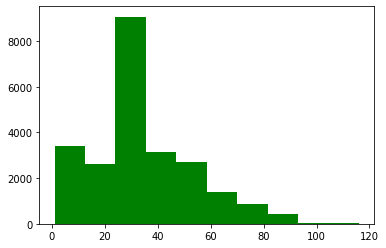

In [ ]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()
# Majority population lies between 20-30 age group. Clearly, 
# the dataset is not very well balanced. So training will 
# not be easy & accurate. We don't want to be
# biased. Try using class weights

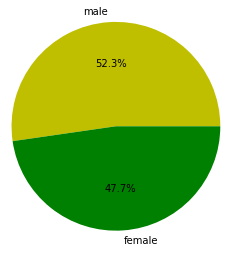

In [ ]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()
# Uniform distribution to a large extent. Although, males slightly exceed females 
# in numbers.No need to change gender in data. Pretty well balanced !
# Lets also visualize this on a bar graph (to get better understanding of numbers)

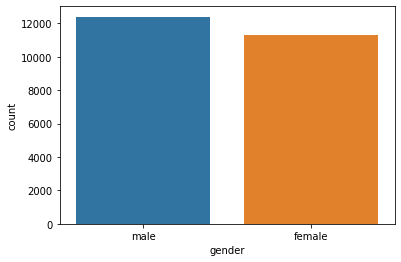

In [ ]:
sns.countplot(x='gender', data=df);

# Males ~ Just over 12k
# Females ~ Just over 11k

In [ ]:
df.groupby(['gender']).mean()             # Mean age by gender

,age
gender,
female,30.678186
male,35.694046


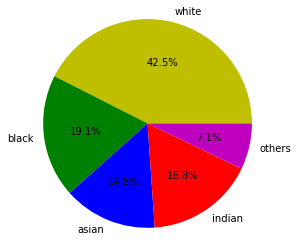

In [ ]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

In [ ]:
df.groupby(['race']).mean()               # Mean age by race

,age
race,
asian,25.867501
black,33.860362
indian,31.532830
others,23.169031
white,37.978276


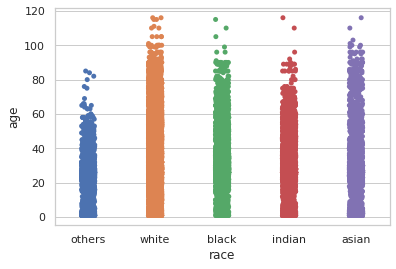

In [ ]:
sns.set(style ="whitegrid") 
_ = sns.stripplot(x='race',y='age',data=df)

# Not very useful :( , we only understand that not many elderly ppl (above 60) 
# in others category are present 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


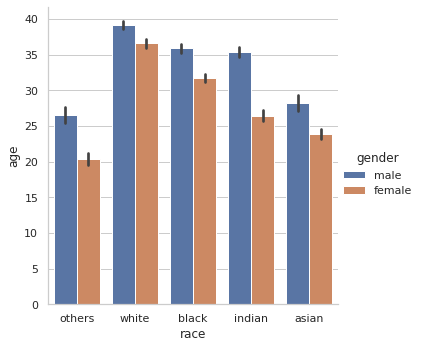

In [ ]:
sns.factorplot('race', 'age', 'gender', data=df,kind='bar');

# Gives the mean age of both genders of all races

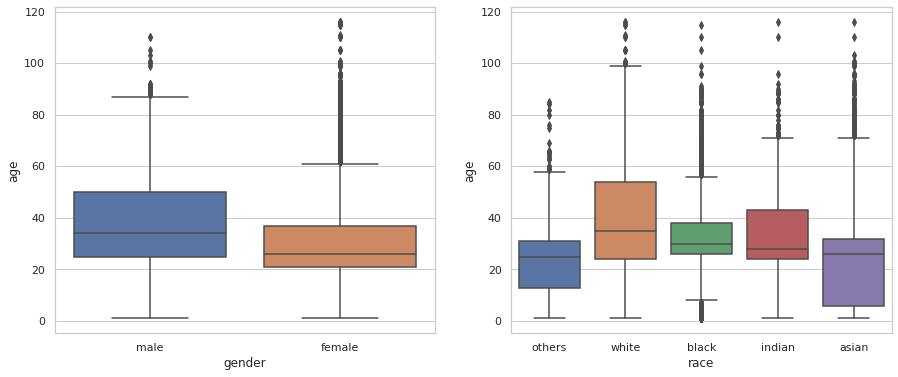

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

## Data Generator
In order to input our data to our Keras multi-output model, we have a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels (instead of just loading all the dataset into the memory at once, which might lead to an out of memory error).

I would be working on the same set of images that I have used in other 2 notebooks (**Age Classifier** & **Gender Classifier**. So, let me load the dataset first.

In [ ]:
train_idx = np.load('/content/drive/My Drive/train_idx.npy') 
val_idx = np.load('/content/drive/My Drive/val_idx.npy') 
test_idx = np.load('/content/drive/My Drive/test_idx.npy') 

In [ ]:
print(train_idx)                     
print(val_idx)
print(test_idx)                             

# All test_idx , train_idx & val_idx are numpy arrays consisting of indices of df

[12138 21443  3908 ... 12093  3048 15433]
[17517 10897  8645 ... 21619  7302  3939]
[12772  2874 18889 ... 11347 23700  1670]


19203
2134
2371



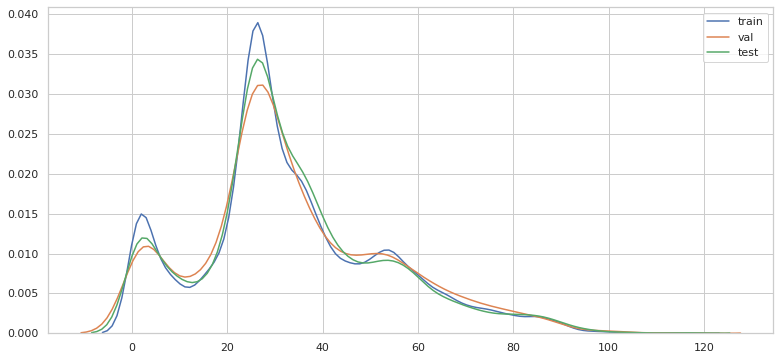

' We see that the distribution for train, test, val each is roughly the same. So \nit using such a division of data is acceptable '

In [ ]:
print(train_idx.size)
print(val_idx.size)
print(test_idx.size)
print('')

y=[]
z=[]
a=[]
for i in range(len(train_idx)):
    x = train_idx[i]
    y.append(int(df[x:x+1]['age']))

for i in range(len(val_idx)):
    x = val_idx[i]
    z.append(int(df[x:x+1]['age']))

for i in range(len(test_idx)):
    x = test_idx[i]
    a.append(int(df[x:x+1]['age']))

plt.figure(figsize=(13,6))
sns.kdeplot(y, label='train', gridsize=100)
sns.kdeplot(z, label='val',  gridsize=100)
sns.kdeplot(a, label='test', gridsize=100)
plt.show()

''' We see that the distribution for train, test, val each is roughly the same. So 
it using such a division of data is acceptable '''

In [ ]:
from PIL import Image
            
def preprocess_image(img_path):
    """
    Used to perform some minor preprocessing on the image before inputting into the network.
    """
    im = Image.open(img_path)
    im = im.resize((180, 180))
    im = np.array(im) / 255.0
    
    return im
        
def generate_images(image_idx, is_training, batch_size=16):
    """
    Used to generate a batch with images when training/testing/validating our Keras model.
    """
    
    # arrays to store our batched data
    images, ages = [], []
    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age']
            file = person['file']
            
            im = preprocess_image(file)

            ages.append(age)
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), np.array(ages)
                images, ages = [], []
                
        if not is_training:
            break
            

## Model Architecture

This is the best model architecture I found for age estimation (regression). It was arrived at after trying many other models such as `Conv2D`, `Conv2DTranspose`. Even in `SeperableConv2D`, I tried it's including/not including it's different arguments such as *kernel_initializer*, *kernel_constraint*, etc.

**NOTE:** All results below, have been obtained once I verified that performance was not improving. I stopped training then, otherwise the model would overfit and lose its generalization ability.

In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import SpatialDropout2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input


input_shape = (180, 180, 3)
inputs = Input(shape=input_shape)

x = SeparableConv2D(64, (3, 3), padding="same",  kernel_initializer='he_uniform')(inputs)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.2)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.2)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128 , kernel_initializer='he_uniform' )(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64 , kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)

x = Dense(1, kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)           

age_model = Model(inputs=inputs, outputs=x)

In [ ]:
from keras.models import load_model
new_model = load_model('/content/drive/My Drive/Colab Notebooks/Age and Gender Detection from Faces/UTKFace Dataset/Age Estimation weights/AE_Adam')

In [ ]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
separable_conv2d_11 (Separab (None, 180, 180, 64)      283       
_________________________________________________________________
activation_19 (Activation)   (None, 180, 180, 64)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 90, 90, 64)        256       
_________________________________________________________________
separable_conv2d_12 (Separab (None, 90, 90, 128)       8896      
_________________________________________________________________
activation_20 (Activation)   (None, 90, 90, 128)       0   

## ADAM Optimizer

### Model training - 



In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.005
	drop = 0.55
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=40  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/40
600/600 [==============================] - 134s 223ms/step - loss: 496.6126 - mae: 16.8980 - mse: 496.6127 - val_loss: 654.1354 - val_mae: 16.7468 - val_mse: 458.8914
Epoch 2/40
600/600 [==============================] - 131s 219ms/step - loss: 230.6666 - mae: 11.4112 - mse: 230.6666 - val_loss: 968.1262 - val_mae: 20.3374 - val_mse: 600.0867
Epoch 3/40
600/600 [==============================] - 131s 218ms/step - loss: 171.7136 - mae: 9.7758 - mse: 171.7136 - val_loss: 176.2883 - val_mae: 9.0411 - val_mse: 146.0942
Epoch 4/40
600/600 [==============================] - 131s 219ms/step - loss: 155.3511 - mae: 9.2206 - mse: 155.3511 - val_loss: 180.0714 - val_mae: 8.7201 - val_mse: 140.4620
Epoch 5/40
600/600 [==============================] - 132s 220ms/step - loss: 151.9019 - mae: 9.0985 - mse: 151.9018 - val_loss: 170.5188 - val_mae: 8.3136 - val_mse: 136.4547
Epoch 6/40
600/600 [==============================] - 132s 220ms/step - loss: 139.8874 - mae: 8.7103 - mse: 139.8874

To better understand our model performance, lemme plot some graphs.

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mae'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Mean Absolute Error',
                  xaxis_title='Epoch',
                  yaxis_title='mae')


fig.show()

<Figure size 432x288 with 0 Axes>

Let's train the model some more, with a new lr of 0.0005. Possibly the lr of 0.00025 was too small for the model to learn by the end of above training.

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.0005
	drop = 0.55
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=20  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/20
600/600 [==============================] - 135s 225ms/step - loss: 66.8388 - mae: 6.0642 - mse: 66.8388 - val_loss: 34.1724 - val_mae: 6.3035 - val_mse: 73.7042
Epoch 2/20
600/600 [==============================] - 132s 219ms/step - loss: 65.7291 - mae: 6.0426 - mse: 65.7291 - val_loss: 55.9451 - val_mae: 6.3035 - val_mse: 77.3307
Epoch 3/20
600/600 [==============================] - 131s 218ms/step - loss: 65.3892 - mae: 6.0114 - mse: 65.3892 - val_loss: 100.6685 - val_mae: 6.2286 - val_mse: 72.4301
Epoch 4/20
600/600 [==============================] - 131s 218ms/step - loss: 63.2278 - mae: 5.9496 - mse: 63.2278 - val_loss: 122.8247 - val_mae: 6.2870 - val_mse: 75.2266
Epoch 5/20
600/600 [==============================] - 131s 219ms/step - loss: 63.4045 - mae: 5.9219 - mse: 63.4044 - val_loss: 125.1567 - val_mae: 6.2654 - val_mse: 74.1210
Epoch 6/20
600/600 [==============================] - 131s 218ms/step - loss: 63.3157 - mae: 5.9043 - mse: 63.3157 - val_loss: 153.5701 -

I found that model performance was not increasing beyod this (infact the model seems to be overfitting now) so I stopped the training. First let me save the model for future use/deployment.

In [ ]:
age_model.save('/content/drive/My Drive/Colab Notebooks/Age and Gender Detection from Faces/Silvertouch Technologies/UTKFace Dataset/AE2')
age_model.save('/content/drive/My Drive/Colab Notebooks/Age and Gender Detection from Faces/Silvertouch Technologies/UTKFace Dataset/AE2.h5')

# Saving the above run model. 

### Model testing - 

In order to assess how our model performs on the test set, let's use our UTK data generator class, but this time using the test indexes. We will then call the `predict_generator` method from our trained model, which will output our the predictions for the test set.

In [ ]:
print(train_idx.size)
print(val_idx.size)
print(test_idx.size)

19203
2134
2371


In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = new_model.predict_generator(test_generator, steps = 2371)
print(results.size)
print('')
print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

2371

[[26.163465 ]
 [32.17791  ]
 [15.984862 ]
 ...
 [34.888096 ]
 [ 3.6490734]
 [22.76588  ]]


In [ ]:
# Let's see the actual ages (of top 3 and last 3 entries in test_idx, cause that's what visible above :P)

print(test_idx)
print(df.iloc[12772]['age'])
print(df.iloc[2874]['age'])
print(df.iloc[18889]['age'])

print(df.iloc[11347]['age'])
print(df.iloc[23700]['age'])
print(df.iloc[1670]['age'])


[12772  2874 18889 ... 11347 23700  1670]
28.0
28.0
8.0
54.0
2.0
15.0


Our model is fairly accurate. Let's get exact performance result on the whole test set.

In [ ]:
count=0
ans=0
for i in test_idx:
    x = df.iloc[i]['age']
    ans+= abs(x-results[count][0])
    count+=1
print(ans/2371)

5.916076824816909


In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
new_model.evaluate(test_generator, steps = 2371)

# O/p of the format - Loss, mae , mse

2371/2371 [==============================] - 19s 8ms/step


[60.308902740478516, 5.91607141494751, 68.88619995117188]

## ADAMAX Optimizer

### Model training - 


In [ ]:
from keras.optimizers import Adamax
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.004
	drop = 0.55
	epochs_drop = 9.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adamax(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=40  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/40
 84/600 [===>..........................] - ETA: 2:49:16 - loss: 1221.6685 - mae: 29.3002 - mse: 1221.6685

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


600/600 [==============================] - 12624s 21s/step - loss: 546.2733 - mae: 17.2480 - mse: 546.2729 - val_loss: 182.3372 - val_mae: 11.2943 - val_mse: 216.8876
Epoch 2/40
600/600 [==============================] - 154s 257ms/step - loss: 198.5685 - mae: 10.2820 - mse: 198.5684 - val_loss: 145.6675 - val_mae: 9.0611 - val_mse: 150.0463
Epoch 3/40
600/600 [==============================] - 153s 255ms/step - loss: 156.1903 - mae: 9.1047 - mse: 156.1903 - val_loss: 138.3265 - val_mae: 8.3177 - val_mse: 120.2016
Epoch 4/40
600/600 [==============================] - 153s 255ms/step - loss: 133.7020 - mae: 8.4581 - mse: 133.7020 - val_loss: 89.0360 - val_mae: 8.5176 - val_mse: 118.1823
Epoch 5/40
600/600 [==============================] - 152s 254ms/step - loss: 122.7014 - mae: 8.1429 - mse: 122.7014 - val_loss: 133.5085 - val_mae: 7.3875 - val_mse: 95.1366
Epoch 6/40
600/600 [==============================] - 153s 254ms/step - loss: 115.7568 - mae: 7.9023 - mse: 115.7569 - val_loss: 1

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=800,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mae'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=800,
                  title='Train vs Val Mean Absolute Error',
                  xaxis_title='Epoch',
                  yaxis_title='mae')


fig.show()

<Figure size 432x288 with 0 Axes>

### Model testing - 

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
age_model.evaluate(test_generator, steps = 2371)

# O/p of the format - Loss, mae , mse

2371/2371 [==============================] - 1141s 481ms/step


[55.872467041015625, 5.6735758781433105, 63.542579650878906]

In [ ]:
# Lets save the history object. That will enable us to draw the graphs again if req

np.save('/content/drive/My Drive/AE_history.npy',history.history)

''' LOAD AS -

 history1=np.load('/content/drive/My Drive/AE_history.npy',allow_pickle='TRUE').item()

 Use history1 everywhere instead of history.history  '''

## SGD Optimizer 

### Model training - 

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.006
	drop = 0.6
	epochs_drop = 9.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=35  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/35
600/600 [==============================] - 133s 222ms/step - loss: 339.7894 - mae: 13.9978 - mse: 339.7892 - val_loss: 361.1812 - val_mae: 12.3140 - val_mse: 304.7221
Epoch 2/35
600/600 [==============================] - 131s 219ms/step - loss: 266.9438 - mae: 12.1724 - mse: 266.9439 - val_loss: 3924.3169 - val_mae: 36.8491 - val_mse: 2685.6863
Epoch 3/35
600/600 [==============================] - 131s 219ms/step - loss: 288.4179 - mae: 12.7775 - mse: 288.4179 - val_loss: 320.1159 - val_mae: 10.8061 - val_mse: 243.0223
Epoch 4/35
600/600 [==============================] - 131s 218ms/step - loss: 210.8935 - mae: 10.6487 - mse: 210.8934 - val_loss: 280.4396 - val_mae: 9.4056 - val_mse: 177.0382
Epoch 5/35
600/600 [==============================] - 132s 220ms/step - loss: 333.1883 - mae: 13.6983 - mse: 333.1885 - val_loss: 516.7490 - val_mae: 14.8223 - val_mse: 406.3014
Epoch 6/35
600/600 [==============================] - 132s 220ms/step - loss: 352.2725 - mae: 14.3320 - mse: 

Let's train the model some more with a new `lr`. Hopefully, this small learning rate will help the model to converge to the minimum

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.00075
	drop = 0.6
	epochs_drop = 9.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=35  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/35
600/600 [==============================] - 134s 223ms/step - loss: 130.4406 - mae: 8.4004 - mse: 130.4406 - val_loss: 72.9089 - val_mae: 7.7402 - val_mse: 105.3379
Epoch 2/35
600/600 [==============================] - 131s 219ms/step - loss: 123.7225 - mae: 8.1707 - mse: 123.7225 - val_loss: 99.5149 - val_mae: 7.5777 - val_mse: 106.6383
Epoch 3/35
600/600 [==============================] - 131s 218ms/step - loss: 122.8035 - mae: 8.1752 - mse: 122.8035 - val_loss: 131.5695 - val_mae: 7.5978 - val_mse: 106.4384
Epoch 4/35
600/600 [==============================] - 130s 217ms/step - loss: 119.7547 - mae: 8.0427 - mse: 119.7547 - val_loss: 161.8513 - val_mae: 7.6446 - val_mse: 106.6769
Epoch 5/35
600/600 [==============================] - 131s 219ms/step - loss: 120.3539 - mae: 8.0906 - mse: 120.3540 - val_loss: 160.9655 - val_mae: 7.6422 - val_mse: 103.6755
Epoch 6/35
600/600 [==============================] - 130s 217ms/step - loss: 120.1241 - mae: 8.0673 - mse: 120.1241 - val

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mae'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Mean Absolute Error',
                  xaxis_title='Epoch',
                  yaxis_title='mae')


fig.show()

<Figure size 432x288 with 0 Axes>

Clearly, there is not much improvement. It seems to me that SGD struggles to get the minima.

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
age_model.evaluate(test_generator, steps = 2371)

# O/p of the format - Loss, mae , mse

2371/2371 [==============================] - 18s 8ms/step


[168.0345001220703, 6.976069927215576, 87.9688491821289]

## SGD optimizer with Momentum

### Model training - 

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.004
	drop = 0.6
	epochs_drop = 9.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0, momentum=0.9)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=35  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/35
131/600 [=====>........................] - ETA: 58:48 - loss: 449.3954 - mae: 16.3378 - mse: 449.3954

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


600/600 [==============================] - 5040s 8s/step - loss: 383.6225 - mae: 15.0286 - mse: 383.6223 - val_loss: 442.6547 - val_mae: 14.0156 - val_mse: 361.3025
Epoch 2/35
600/600 [==============================] - 193s 322ms/step - loss: 332.0990 - mae: 13.9231 - mse: 332.0992 - val_loss: 548.2034 - val_mae: 13.9638 - val_mse: 370.1403
Epoch 3/35
600/600 [==============================] - 192s 321ms/step - loss: 308.8318 - mae: 13.4516 - mse: 308.8319 - val_loss: 302.6132 - val_mae: 12.6987 - val_mse: 288.6753
Epoch 4/35
600/600 [==============================] - 193s 321ms/step - loss: 290.3007 - mae: 12.9413 - mse: 290.3007 - val_loss: 375.3905 - val_mae: 11.9816 - val_mse: 271.1891
Epoch 5/35
600/600 [==============================] - 193s 321ms/step - loss: 268.4036 - mae: 12.2422 - mse: 268.4036 - val_loss: 285.2560 - val_mae: 13.0084 - val_mse: 323.7633
Epoch 6/35
600/600 [==============================] - 192s 320ms/step - loss: 255.8160 - mae: 11.8873 - mse: 255.8160 - val

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.0004
	drop = 0.6
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0, momentum=0.9)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=35  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/35
600/600 [==============================] - 195s 325ms/step - loss: 184.6921 - mae: 10.0674 - mse: 184.6921 - val_loss: 178.0653 - val_mae: 9.7430 - val_mse: 162.8996
Epoch 2/35
600/600 [==============================] - 193s 322ms/step - loss: 178.7611 - mae: 9.8629 - mse: 178.7611 - val_loss: 200.8042 - val_mae: 10.1857 - val_mse: 169.3924
Epoch 3/35
600/600 [==============================] - 192s 320ms/step - loss: 176.9419 - mae: 9.8325 - mse: 176.9419 - val_loss: 190.5294 - val_mae: 10.1030 - val_mse: 170.7226
Epoch 4/35
600/600 [==============================] - 192s 320ms/step - loss: 175.7110 - mae: 9.7805 - mse: 175.7110 - val_loss: 264.7978 - val_mae: 9.7143 - val_mse: 163.1962
Epoch 5/35
600/600 [==============================] - 192s 319ms/step - loss: 174.2618 - mae: 9.7702 - mse: 174.2619 - val_loss: 254.4804 - val_mae: 9.8159 - val_mse: 163.0912
Epoch 6/35
600/600 [==============================] - 192s 320ms/step - loss: 190.0031 - mae: 10.1770 - mse: 190.0030

### Model testing - 

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
age_model.evaluate(test_generator, steps = 2371)

# O/p of the format - Loss, mae , mse

2371/2371 [==============================] - 26s 11ms/step


[356.9361267089844, 8.577977180480957, 129.62869262695312]

It is pretty clear, that SGD even with momentum doens't seem to be performing well in regression tasks at least. The model is struggling to learn.

## NADAM Optimizer

### Model training - 

In [ ]:
from keras.optimizers import Nadam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.004
	drop = 0.55
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Nadam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=40  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/40
600/600 [==============================] - 135s 225ms/step - loss: 491.1004 - mae: 16.4644 - mse: 491.1006 - val_loss: 389.6859 - val_mae: 13.8956 - val_mse: 316.7822
Epoch 2/40
600/600 [==============================] - 132s 221ms/step - loss: 287.6055 - mae: 12.6317 - mse: 287.6054 - val_loss: 436.6376 - val_mae: 11.9735 - val_mse: 288.4094
Epoch 3/40
600/600 [==============================] - 132s 219ms/step - loss: 235.9626 - mae: 11.2267 - mse: 235.9626 - val_loss: 241.4526 - val_mae: 10.9261 - val_mse: 231.5452
Epoch 4/40
600/600 [==============================] - 132s 220ms/step - loss: 203.6175 - mae: 10.4281 - mse: 203.6175 - val_loss: 209.5607 - val_mae: 9.3801 - val_mse: 172.5403
Epoch 5/40
600/600 [==============================] - 132s 220ms/step - loss: 176.0176 - mae: 9.6797 - mse: 176.0175 - val_loss: 196.6084 - val_mae: 9.8880 - val_mse: 175.7350
Epoch 6/40
600/600 [==============================] - 132s 220ms/step - loss: 158.3159 - mae: 9.2048 - mse: 158.3

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mae'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Mean Absolute Error',
                  xaxis_title='Epoch',
                  yaxis_title='mae')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
age_model.evaluate(test_generator, steps = 2371)

# O/p of the format - Loss, mae , mse

2371/2371 [==============================] - 18s 8ms/step


[84.68167877197266, 5.858747482299805, 65.38154602050781]

 This results are pretty good. It means that on average, our best model (**Adamax** ) will make a prediction off by about **5.67 yrs** to the actual age.
 It seems to have great generalizability as well which is vindicated by the results of testing on external images.



## Results on some external images - 

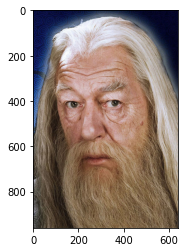

[[76.202835]]


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/dd1.jpg"                                     
age_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
print(age_pred)


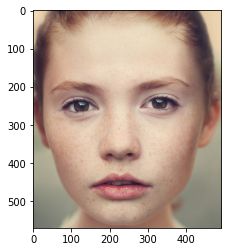

[[9.907316]]


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/teen2.jpg"                                     
age_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
print(age_pred)


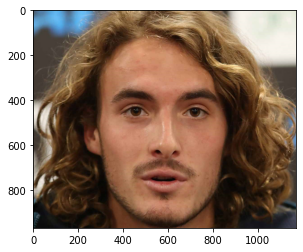

[[24.46875]]


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/tsit.jpg"                                     
age_pred = age_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
print(age_pred)
